In [ ]:
#Import the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GRU, Bidirectional, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
np.random.seed(42)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Read and check the dataset
sleep = pd.read_csv("/content/drive/MyDrive/Colab Notebooks (1)/Sleep Health and Lifestyle Dataset.csv")
sleep.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,New_Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None,0
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None,0
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None,0
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,1
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,1


In [ ]:
#The missing values probably mean that the person doesn't have a sickness
#Replace NaN-s with No Disorder
sleep["Sleep Disorder"] = sleep["Sleep Disorder"].fillna("No Disorder")

In [ ]:
#Separate the Blood Pressure values to Systolic and Diastolic
sleep[["Systoli", "Diastolic"]] = sleep["Blood Pressure"].str.split("/", expand = True).astype(int)

In [ ]:
#Drop the Id column
sleep.drop("Person ID", axis = 1, inplace = True)

In [ ]:
#Lets have a quick look on the basic correlations
corr = sleep.corr(numeric_only = True)
corr

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,New_Sleep Disorder,Systoli,Diastolic
Age,1.000000,0.309512,0.403054,0.123237,-0.354492,-0.179302,0.034052,0.277629,0.575099,0.556225
Sleep Duration,0.309512,1.000000,0.894567,0.167616,-0.782285,-0.448326,-0.077701,-0.440843,-0.238329,-0.245357
Quality of Sleep,0.403054,0.894567,1.000000,0.154686,-0.879231,-0.601089,-0.016692,-0.414336,-0.196125,-0.195241
Physical Activity Level,0.123237,0.167616,0.154686,1.000000,0.038130,0.219670,0.776583,-0.161588,0.255506,0.359932
Stress Level,-0.354492,-0.782285,-0.879231,0.038130,1.000000,0.666084,0.238846,0.199206,0.153943,0.150835
Heart Rate,-0.179302,-0.448326,-0.601089,0.219670,0.666084,1.000000,0.019801,0.167341,0.282890,0.261548
Daily Steps,0.034052,-0.077701,-0.016692,0.776583,0.238846,0.019801,1.000000,-0.182029,0.126123,0.259134
New_Sleep Disorder,0.277629,-0.440843,-0.414336,-0.161588,0.199206,0.167341,-0.182029,1.000000,0.529389,0.514998
Systoli,0.575099,-0.238329,-0.196125,0.255506,0.153943,0.282890,0.126123,0.529389,1.000000,0.974247
Diastolic,0.556225,-0.245357,-0.195241,0.359932,0.150835,0.261548,0.259134,0.514998,0.974247,1.000000


#** EDA**

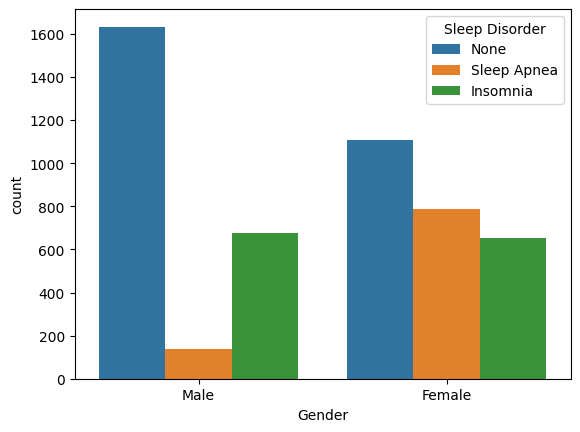

In [ ]:
#Sleep disorder based on gender
sns.countplot(x = "Gender", hue = "Sleep Disorder", data = sleep);

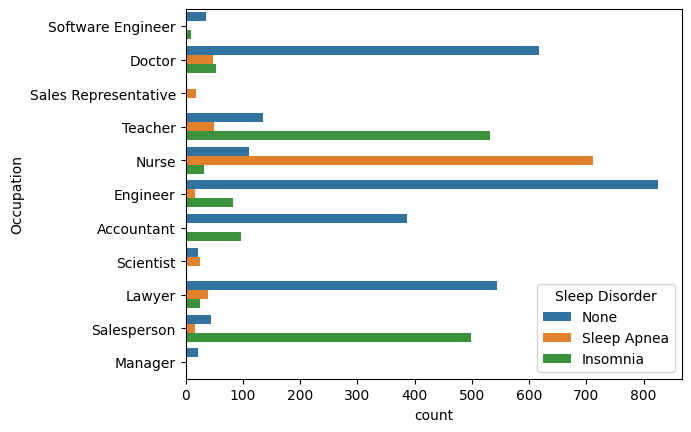

In [ ]:
#Sleep disorder based on occupation
sns.countplot(y = "Occupation", hue = "Sleep Disorder", data = sleep);

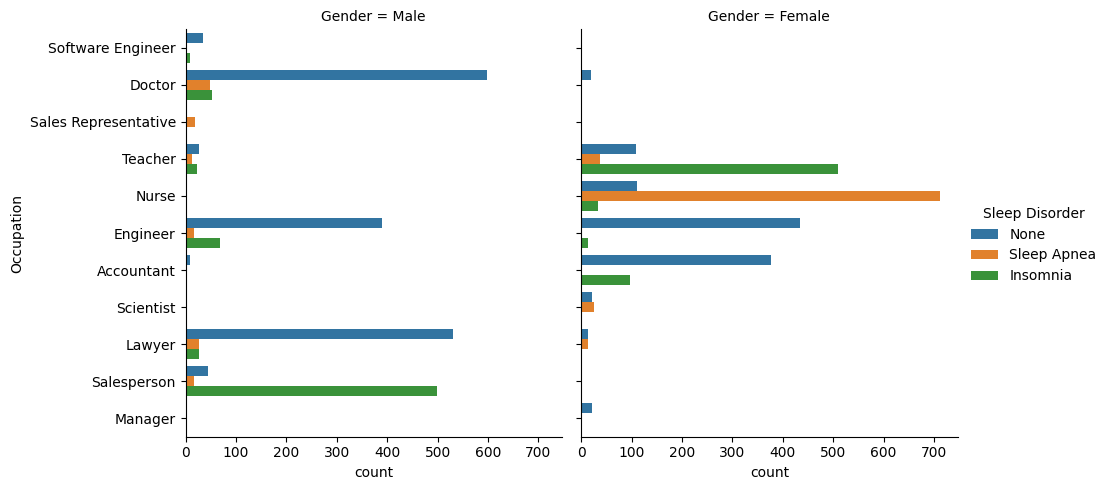

In [ ]:
#Let's see, which occupations are more threatened by sleeping disorders based also on gender, to check for imbalances
sns.catplot(y="Occupation", hue="Sleep Disorder",col= "Gender",kind = "count", data=sleep)
plt.show()

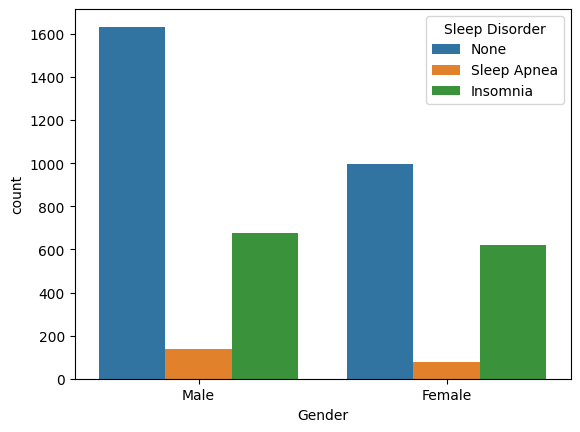

In [ ]:
#It seems there is a strong cofounding factor of occupation. We can see that jobs which probably pay less, like nurse are done by females
#while higher paying jobs. like doctor, by men.
#Lets see the distribution in gender if we don't include the nurses
no_nurse = sleep.loc[sleep["Occupation"] != "Nurse"]
sns.countplot(x = "Gender", hue = "Sleep Disorder", data = no_nurse);

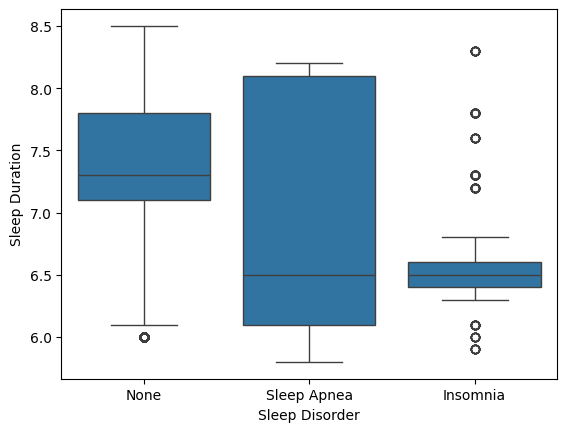

In [ ]:
#Create boxplots about the sleep length
sns.boxplot(x = "Sleep Disorder",  y = "Sleep Duration", data = sleep);

In [ ]:
#Let's find out if there are some other variables, which are pushing nurses to the direction of sleep apnea
#First make another correlation, but now numeric values for sleep disorders

sleep_dummies = pd.get_dummies(sleep["Sleep Disorder"])
sleep_new = sleep.drop("Sleep Disorder", axis = 1)
sleep_disorders = pd.concat([sleep_new, sleep_dummies], axis = 1)

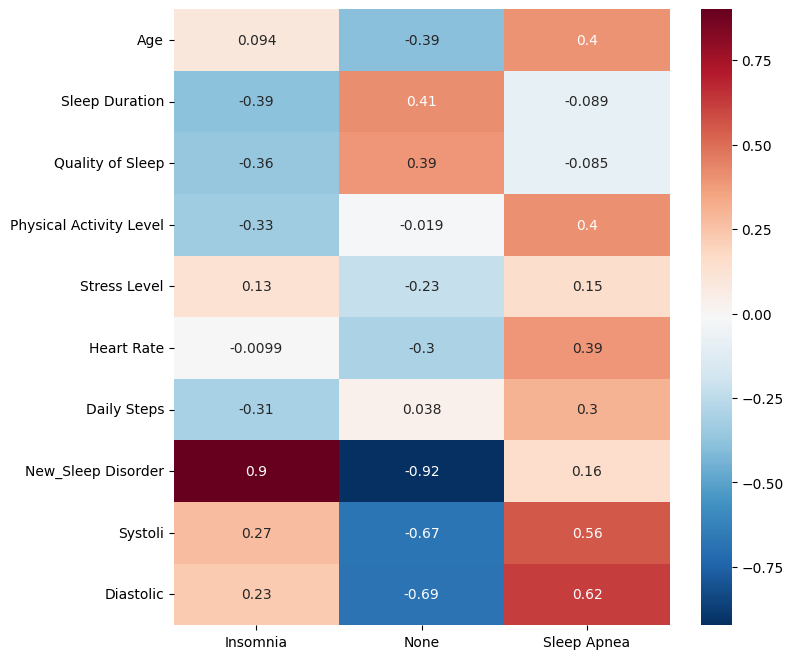

In [ ]:
#Make a heatmap, see what variables are connected to which outcome
corr_2 = sleep_disorders.corr(numeric_only = True)
plt.figure(figsize = (8,8))
sns.heatmap(corr_2.iloc[:-3, -3:], annot = True, cmap='RdBu_r');

In [ ]:
print(sleep_disorders.columns)


Index(['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category',
       'Blood Pressure', 'Heart Rate', 'Daily Steps', 'New_Sleep Disorder',
       'Systoli', 'Diastolic', 'Insomnia', 'None', 'Sleep Apnea'],
      dtype='object')


In [ ]:
no_normal = sleep_disorders.drop("None".strip(), axis=1)
if "No Disorder" in sleep_disorders.columns:
    no_normal = sleep_disorders.drop("No Disorder", axis=1)
else:
    print("Column 'No Disorder' not found.")


Column 'No Disorder' not found.


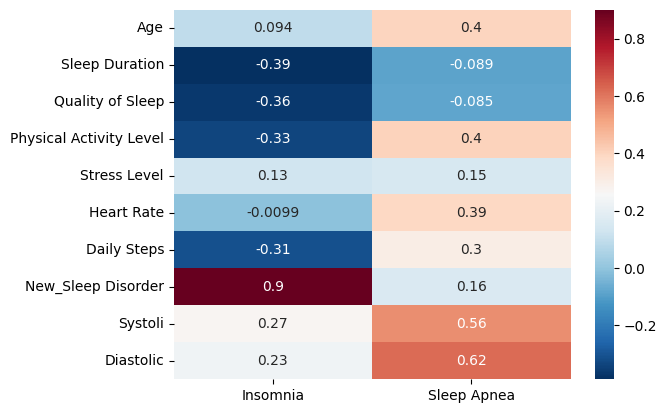

In [ ]:

correlation_4 = no_normal.corr(numeric_only = True)
sns.heatmap(correlation_4.iloc[:-2, -2:], annot = True, cmap='RdBu_r');

# **Train Test Set Value**

In [ ]:
#Make a train and a test set
from sklearn.model_selection import train_test_split
y = sleep_disorders[["None", "Insomnia", "Sleep Apnea"]]
X = sleep_disorders.drop(["Insomnia", "None", "Sleep Apnea", "Blood Pressure"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
#Generating dummies and standardize
X_train = pd.get_dummies(X_train, columns=["Gender", "Occupation"])
X_test = pd.get_dummies(X_test, columns=["Gender", "Occupation"])
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [ ]:

# Make a train and a test set
y = sleep_disorders[["None", "Insomnia", "Sleep Apnea"]]
X = sleep_disorders.drop(["Insomnia", "None", "Sleep Apnea", "Blood Pressure"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [ ]:

# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Create transformers for numeric and categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with preprocessing and scaling
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('scaler', StandardScaler())])


In [ ]:

# Fit and transform the training data
X_train_scaled = pipeline.fit_transform(X_train)

# Transform the test data using the same pipeline
X_test_scaled = pipeline.transform(X_test)


In [ ]:
#Seeing the results with a KNN model
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid
param_grid = {'n_neighbors': [1, 3, 5, 6, 7, 9, 11],
              'weights': ['uniform', 'distance']}
# Create a KNN classifier object
knn = KNeighborsClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)
# Train the classifier using your training data
knn.fit(X_train_scaled, y_train)

# Make predictions on your test data
y_pred = knn.predict(X_test_scaled)

{'n_neighbors': 1, 'weights': 'uniform'}


In [ ]:
from sklearn import metrics
result = metrics.accuracy_score(y_pred,y_test)
print(result)
classification_rep = metrics.classification_report(y_test, y_pred)
print(classification_rep)

1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       690
           1       1.00      1.00      1.00       338
           2       1.00      1.00      1.00       222

   micro avg       1.00      1.00      1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250
 samples avg       1.00      1.00      1.00      1250



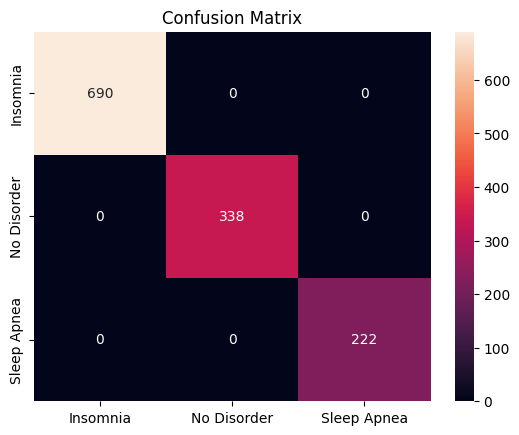

In [ ]:
#Create the labels for the matrix
disease_labels = ["Insomnia", "No Disorder", "Sleep Apnea"]
#Create a confusion matrix
cm = metrics.confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
# Create a figure object
fig = plt.figure()
# Add an ax object to the figure
ax = fig.add_subplot(111)
#Create the visualisation
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
sns.heatmap(cm, annot=True, fmt='g', xticklabels=disease_labels, yticklabels=disease_labels);

# **DecisionTreeClassifier**

Classification Report for Insomnia:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       912
           1       0.90      0.91      0.90       338

    accuracy                           0.95      1250
   macro avg       0.93      0.93      0.93      1250
weighted avg       0.95      0.95      0.95      1250

Classification Report for Sleep Apnea:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1028
           1       0.88      0.88      0.88       222

    accuracy                           0.96      1250
   macro avg       0.93      0.93      0.93      1250
weighted avg       0.96      0.96      0.96      1250

Classification Report for New_Sleep Disorder:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       690
           1       0.88      0.88      0.88       222
           2       0.90      0.91      0.90       338

    acc

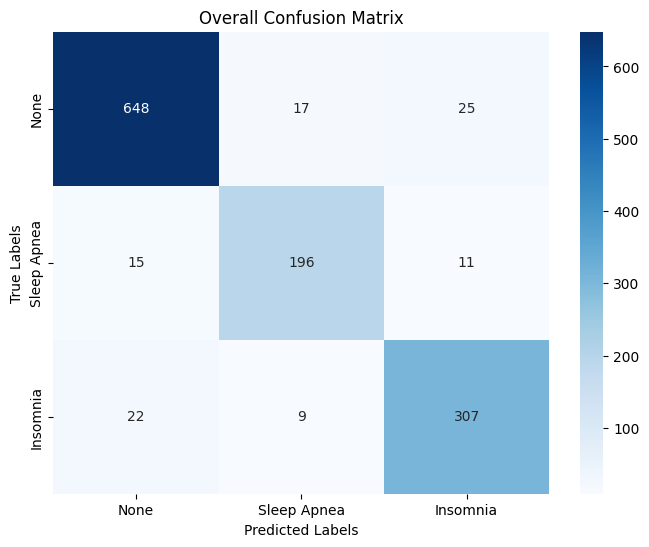

In [ ]:


# Make a train and a test set
y = sleep_disorders[["Insomnia", "Sleep Apnea", 'New_Sleep Disorder']]
X = sleep_disorders.drop(["Insomnia", "None", "Sleep Apnea", "Blood Pressure", 'New_Sleep Disorder'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns



# Create transformers for numeric and categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')


# Create preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with preprocessing, scaling, and decision tree
pipeline_dtc = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', DecisionTreeClassifier(random_state=42))])

# Fit the pipeline to the training data
pipeline_dtc.fit(X_train, y_train)

# Predict on the test set
y_pred_dtc = pipeline_dtc.predict(X_test)

# Iterate over each column and print classification report
for i, column in enumerate(y.columns):
    y_true_column = y_test.iloc[:, i]
    y_pred_column = y_pred_dtc[:, i]

    print(f"Classification Report for {column}:")
    print(classification_report(y_true_column, y_pred_column))

    # Print confusion matrix
    conf_matrix_column = confusion_matrix(y_true_column, y_pred_column)



# Visualize overall confusion matrix with heatmap
conf_matrix_overall = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(y_pred_dtc, axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_overall, annot=True, fmt='d', cmap='Blues', xticklabels=['None', 'Sleep Apnea', 'Insomnia'], yticklabels=['None', 'Sleep Apnea', 'Insomnia'])

plt.title("Overall Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### RF and GN

In [ ]:
sleep_disorders = pd.read_csv("/content/drive/MyDrive/Colab Notebooks (1)/Sleep Health and Lifestyle Dataset.csv")
# Extract features and target variable
y = sleep_disorders["New_Sleep Disorder"]
X = sleep_disorders.drop(["Person ID", "Sleep Disorder", "New_Sleep Disorder", "Blood Pressure"], axis=1)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transformers for numeric and categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with preprocessing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Transform the data
X_transformed = pipeline.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.25, random_state=42)

# Build and train the Random Forest classifier with hyperparameter tuning
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Build and train the Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions on the test set for both models
y_pred_rf = rf_model.predict(X_test)
y_pred_nb = nb_model.predict(X_test)

# Calculate accuracy for both models
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

print(f"Random Forest Accuracy: {accuracy_rf}")
print(f"Gaussian Naive Bayes Accuracy: {accuracy_nb}")

# Print additional metrics for Random Forest
classification_report_rf = classification_report(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("Random Forest Metrics:")
print(f"Classification Report:\n{classification_report_rf}")


# Print additional metrics for Gaussian Naive Bayes
classification_report_nb = classification_report(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

print("Gaussian Naive Bayes Metrics:")
print(f"Classification Report:\n{classification_report_nb}")



Random Forest Accuracy: 0.9224
Gaussian Naive Bayes Accuracy: 0.8576
Random Forest Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       690
           1       0.88      0.88      0.88       222
           2       0.91      0.90      0.90       338

    accuracy                           0.92      1250
   macro avg       0.91      0.91      0.91      1250
weighted avg       0.92      0.92      0.92      1250

Gaussian Naive Bayes Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       690
           1       0.76      0.85      0.80       222
           2       0.78      0.86      0.81       338

    accuracy                           0.86      1250
   macro avg       0.83      0.86      0.84      1250
weighted avg       0.87      0.86      0.86      1250



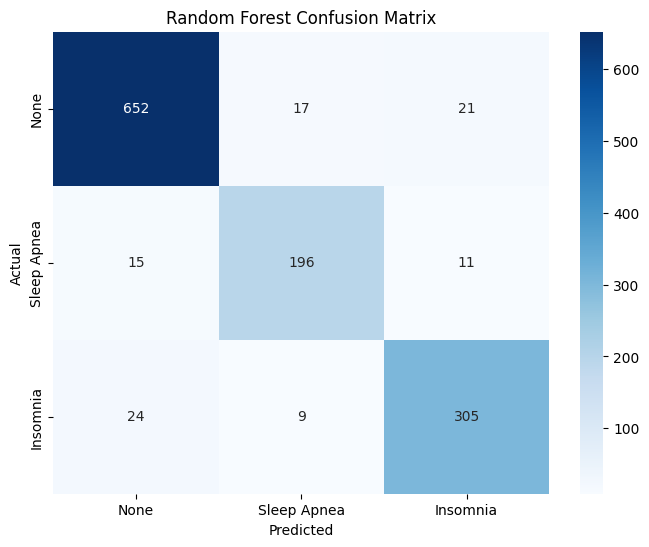

In [ ]:
# Plot confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['None', 'Sleep Apnea', 'Insomnia'], yticklabels=['None', 'Sleep Apnea', 'Insomnia'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

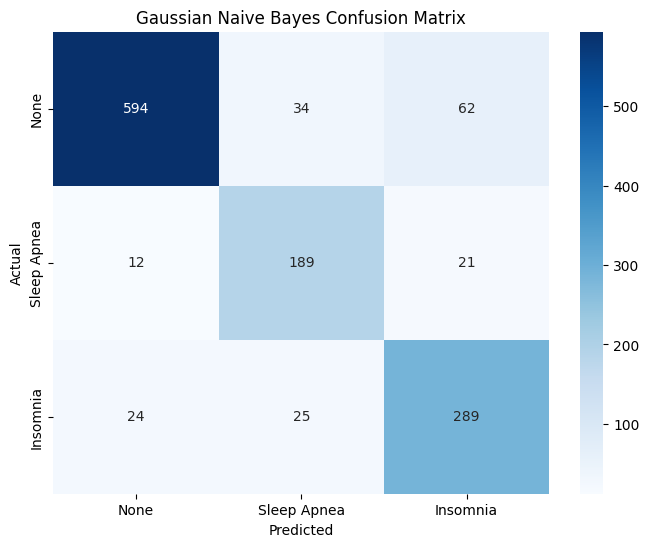

In [ ]:

# Plot confusion matrix for Gaussian Naive Bayes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['None', 'Sleep Apnea', 'Insomnia'], yticklabels=['None', 'Sleep Apnea', 'Insomnia'])
plt.title('Gaussian Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### CNN MODEL

In [ ]:
X_scaled = pipeline.fit_transform(X)

# Reshape the data for CNN input
X_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# One-hot encode the target variable with 3 classes
y_encoded = to_categorical(y, num_classes=3)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_encoded, test_size=0.25, random_state=42)
# Build the CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_cnn.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=1))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))  # Increase the number of neurons
cnn_model.add(Dropout(0.8))
cnn_model.add(Dense(3, activation='softmax'))

# Compile the CNN model with a lower learning rate
cnn_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model with more epochs
history2 = cnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.3)


Epoch 1/20
83/83 [==============================] - 2s 7ms/step - loss: 0.6146 - accuracy: 0.8122 - val_loss: 0.3862 - val_accuracy: 0.8978
Epoch 2/20
83/83 [==============================] - 0s 5ms/step - loss: 0.4516 - accuracy: 0.8910 - val_loss: 0.3424 - val_accuracy: 0.9102
Epoch 3/20
83/83 [==============================] - 0s 4ms/step - loss: 0.4076 - accuracy: 0.8998 - val_loss: 0.3304 - val_accuracy: 0.9147
Epoch 4/20
83/83 [==============================] - 0s 4ms/step - loss: 0.3919 - accuracy: 0.9063 - val_loss: 0.3178 - val_accuracy: 0.9227
Epoch 5/20
83/83 [==============================] - 0s 5ms/step - loss: 0.3844 - accuracy: 0.9101 - val_loss: 0.3118 - val_accuracy: 0.9280
Epoch 6/20
83/83 [==============================] - 0s 5ms/step - loss: 0.3724 - accuracy: 0.9131 - val_loss: 0.3078 - val_accuracy: 0.9280
Epoch 7/20
83/83 [==============================] - 0s 5ms/step - loss: 0.3690 - accuracy: 0.9143 - val_loss: 0.3053 - val_accuracy: 0.9280
Epoch 8/20
83/83 [==

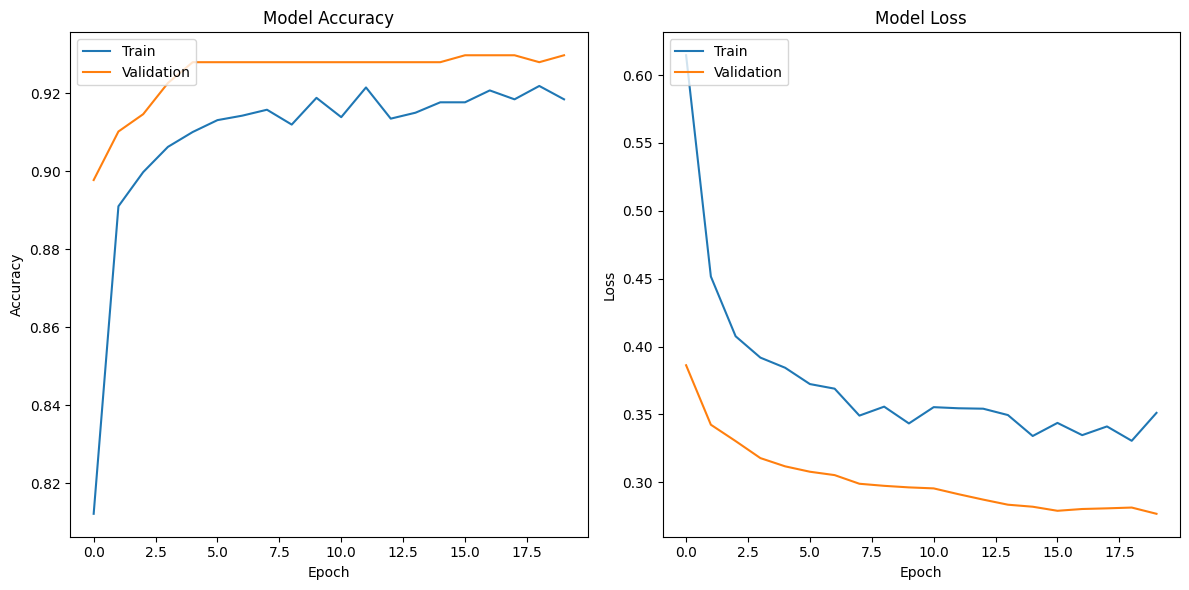

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the CNN model on test data
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
y_test_categorical = np.argmax(y_test, axis=1)

# Print metrics for CNN
accuracy_cnn = np.sum(y_pred_cnn == y_test_categorical) / len(y_test_categorical)
classification_report_cnn = classification_report(y_test_categorical, y_pred_cnn)
conf_matrix_cnn = confusion_matrix(y_test_categorical, y_pred_cnn)

print("CNN Model Metrics:")
print(f"Accuracy: {accuracy_cnn}")
print(f"Classification Report:\n{classification_report_cnn}")

40/40 [==============================] - 0s 2ms/step
CNN Model Metrics:
Accuracy: 0.9184
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       690
           1       0.88      0.88      0.88       222
           2       0.89      0.90      0.90       338

    accuracy                           0.92      1250
   macro avg       0.91      0.91      0.91      1250
weighted avg       0.92      0.92      0.92      1250



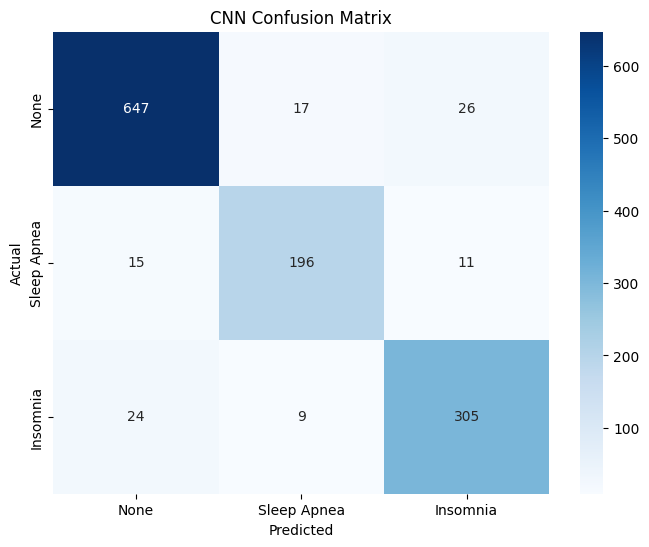

In [ ]:
# Plot the confusion matrix for CNN
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=['None', 'Sleep Apnea', 'Insomnia'], yticklabels=['None', 'Sleep Apnea', 'Insomnia'])
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# CNN+BI-LSTM

In [ ]:

# Build the CNN + Bidirectional LSTM model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_cnn.shape[1], 1)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
cnn_lstm_model.add(Bidirectional(LSTM(32, activation='relu')))
cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(Dense(128, activation='relu'))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(Dense(64, activation='relu'))
cnn_lstm_model.add(Dense(3, activation='softmax'))

# Compile the CNN + Bidirectional LSTM model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN + Bidirectional LSTM model
history1=cnn_lstm_model.fit(X_train, y_train, epochs=30, batch_size=8, validation_split=0.2)



Epoch 1/30
375/375 [==============================] - 28s 56ms/step - loss: 0.6242 - accuracy: 0.7767 - val_loss: 0.4053 - val_accuracy: 0.8893
Epoch 2/30
375/375 [==============================] - 20s 54ms/step - loss: 0.4115 - accuracy: 0.8843 - val_loss: 0.3217 - val_accuracy: 0.9093
Epoch 3/30
375/375 [==============================] - 19s 49ms/step - loss: 0.3710 - accuracy: 0.8977 - val_loss: 0.3039 - val_accuracy: 0.9200
Epoch 4/30
375/375 [==============================] - 17s 45ms/step - loss: 0.3444 - accuracy: 0.9077 - val_loss: 0.2974 - val_accuracy: 0.9227
Epoch 5/30
375/375 [==============================] - 17s 45ms/step - loss: 0.3256 - accuracy: 0.9200 - val_loss: 0.2789 - val_accuracy: 0.9320
Epoch 6/30
375/375 [==============================] - 18s 49ms/step - loss: 0.3421 - accuracy: 0.9140 - val_loss: 0.2889 - val_accuracy: 0.9227
Epoch 7/30
375/375 [==============================] - 17s 46ms/step - loss: 0.3147 - accuracy: 0.9180 - val_loss: 0.2656 - val_accuracy:

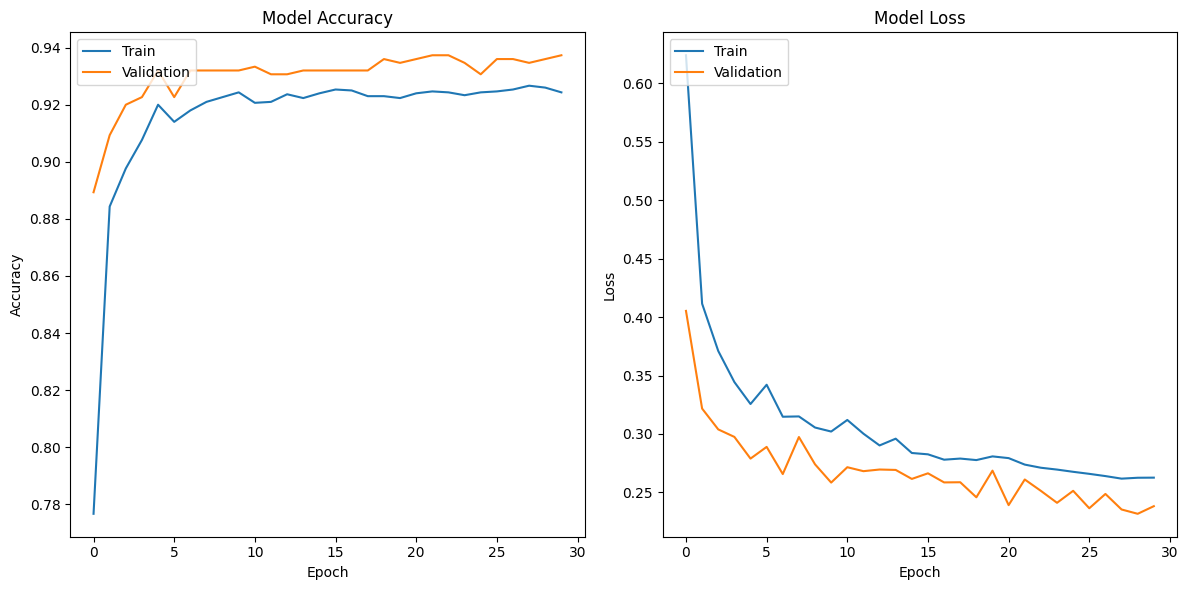

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the CNN + Bidirectional LSTM model on test data
y_pred_cnn_lstm = np.argmax(cnn_lstm_model.predict(X_test), axis=1)

# Print metrics for CNN + Bidirectional LSTM
accuracy_cnn_lstm = np.sum(y_pred_cnn_lstm == y_test_categorical) / len(y_test_categorical)
classification_report_cnn_lstm = classification_report(y_test_categorical, y_pred_cnn_lstm)
conf_matrix_cnn_lstm = confusion_matrix(y_test_categorical, y_pred_cnn_lstm)

print("CNN + Bidirectional LSTM Model Metrics:")
print(f"Accuracy: {accuracy_cnn_lstm}")
print(f"Classification Report:\n{classification_report_cnn_lstm}")


40/40 [==============================] - 0s 8ms/step
CNN + Bidirectional LSTM Model Metrics:
Accuracy: 0.9216
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       690
           1       0.91      0.87      0.89       222
           2       0.89      0.92      0.90       338

    accuracy                           0.92      1250
   macro avg       0.91      0.91      0.91      1250
weighted avg       0.92      0.92      0.92      1250



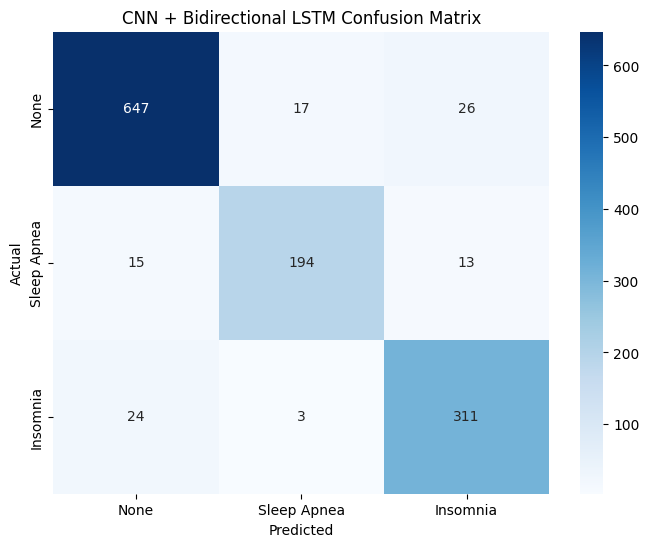

In [ ]:
# Plot the confusion matrix for CNN + Bidirectional LSTM
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['None', 'Sleep Apnea', 'Insomnia'], yticklabels=['None', 'Sleep Apnea', 'Insomnia'])
plt.title('CNN + Bidirectional LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

40/40 [==============================] - 1s 16ms/step


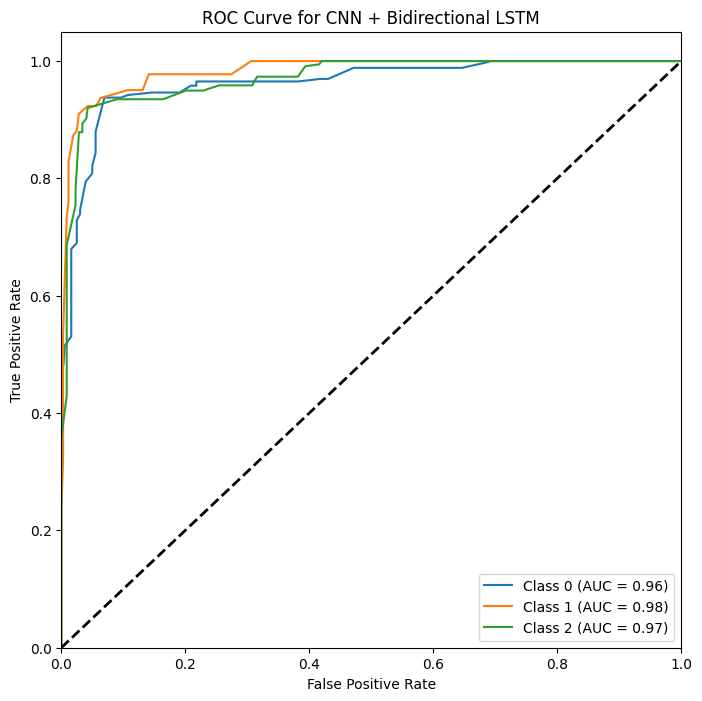

In [ ]:
from sklearn.metrics import roc_curve, auc
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Get predicted probabilities for each class
y_pred_prob_cnn_lstm = cnn_lstm_model.predict(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 3  # Replace this with the actual number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob_cnn_lstm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN + Bidirectional LSTM')
plt.legend(loc='lower right')
plt.show()


# Accuracy Scores Comparison

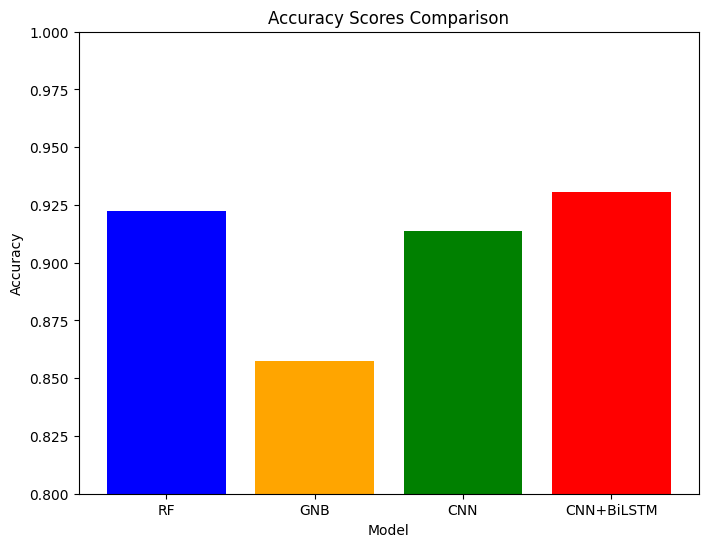

In [ ]:
import matplotlib.pyplot as plt

# Accuracy scores
accuracy_scores = {"RF": 0.9224, "GNB": 0.8576, "CNN": 0.9136, "CNN+BiLSTM": 0.9304}

# Creating bar chart
plt.figure(figsize=(8, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['blue', 'orange', 'green', 'red'])
plt.title('Accuracy Scores Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # Set y-axis limits for better visualization
plt.show()

# extra